In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('data/application_train.csv')
data.head()

test_data = pd.read_csv('data/application_test.csv')

In [3]:
data.shape

(307511, 122)

### 0 indicates loan repaid on time

In [4]:
# there are 122 features, 1 of them is the target value
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

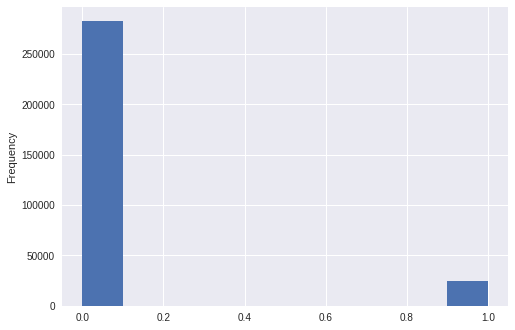

In [5]:
data['TARGET'].astype(int).plot.hist()
plt.show()

## Imbalanced class problem
We see that the number of times loan was repayed is much more than the number of times it was not. This is the case of imbalanced class problem where the number of positives is far more than the number of negatives.

In [6]:
# function to calculate missing values by column
def missing_values_table(df):
    # series of total missing values in every column
    mis_val = df.isnull().sum()

    # series of percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # make a table of missing values and their percentages
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # mis_val_table.head()

    # rename the columns
    mis_val_table_ren = mis_val_table.rename(columns = {0: 'Missing values', 1: '% of Total values'})
    # mis_val_table_ren.head()

    # sort the table by % of missing values - descending
    # select the percentages which are not zero
    # then sort them in descending order
    mis_val_table_ren = mis_val_table_ren[mis_val_table_ren.iloc[:, 1] != 0].sort_values('% of Total values', ascending=False)
    # mis_val_table_ren.head()

    print("Your selected data frame has " + str(df.shape[1]) + " columns out of which " + str(len(mis_val_table_ren)) + " columns have missing values")
    
    
missing_values_table(data)

Your selected data frame has 122 columns out of which 67 columns have missing values


In [7]:
# take a look at data types of each col
data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### find the number of unique classes in each object column

In [8]:
data.select_dtypes(include=['object']).nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

# Encoding categorical variables

A machine learning model cannot deal with categorical variables (except for some models). Therefore we need to find a way to encode them (represent as numbers) before handing them to the model.

## Label encoding

This method involves assigning one label for each category

| Occupation    | Label         |
| ------------- |:-------------:|
| programmer    | 0             |
| data scientist| 1             |
| Engineer      | 2             |



The problem with label encoding is that the assignment of integers is random and changes every time we run the function. Also the model might give higher priority to larger labels. Label encoding can be used when we have only 2 unique values.

## One hot encoding

The problem with label encoding is solved by one hot encoding. It creates a new column for each category and uses only binary values. The downside of one hot encoding is that the number of features can explode if the categorical variables have many categories. To deal with this we can perform PCA (or other dimensionality reduction methods) followed by one hot encoding.

| Occupation    | Occupation_prog| Occupation_ds | Occupation_eng |
| ------------- |:-------------: |:-------------:|:-------------: |
| programmer    | 1              | 0             | 0              |
| data scientist| 0              | 1             | 0              |
| Engineer      | 0              | 0             | 1              |

In [9]:
# we will use label encoding for variables with only 2 categories
# and one hot encoding for the rest

# create a label encoder
le = LabelEncoder()

# keep a count of the number of columns encoded
le_count = 0

for col in data:
    
    # if the type of column is object
    if data[col].dtype == 'object':
        
        # and the len of unique values is 2 or less
        if len(list(data[col].unique())) <= 2:
            
            # fit it using label encoder
            le.fit(data[col])
            
            # check the classes
            # print(le.classes_)
            
            # insert the values in dataframe
            data[col] = le.transform(data[col])
            test_data[col] = le.transform(test_data[col])
            
            # increase the count of number of columns label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [10]:
# one-hot encoding of categorical variables
data = pd.get_dummies(data)
test_data = pd.get_dummies(test_data)

print(data.shape)
print(test_data.shape)

(307511, 243)
(48744, 239)


# Align the data together

The above cell shows a difference in the number of features in training and testing data. Consider a categorical variable with 5 categories. Suppose only 4 of these are present in the testing data, then test data will have only 4 columns after one hot encoding. To solve this problem we need to align the training and testing data together to make sure they have the same columns.

In [11]:
# store the target variable seperately first, we need it later
train_labels = data['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
data, test_data = data.align(test_data, join = 'inner', axis = 1)

# Add the target back in
data['TARGET'] = train_labels

print('Training Features shape: ', data.shape)
print('Testing Features shape: ', test_data.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


# Anomalies

Anomalies can occure due to mis-typed numbers, errors in measuring equipment or numbers may be valid but extreme. Anomaly detection is an important aspect of EDA.

In [12]:
# Days_Birth is negative because it is recorded relative to the loan application
# to see it in years we multiply by -1 and divide by 365
# the more negative the value more is the age
# -25229 -> 69 years
# -7489 -> 20 years
(data['DAYS_BIRTH']  / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [13]:
(data['DAYS_EMPLOYED'] / 365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

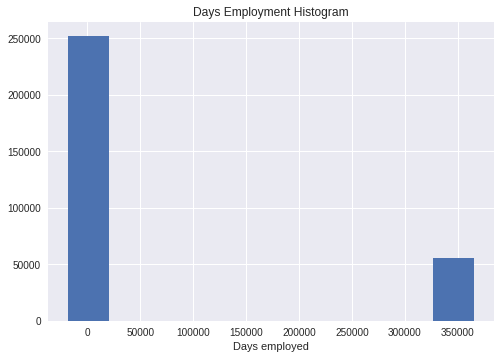

In [14]:
# the max value is positive and beyond 1000 years
data['DAYS_EMPLOYED'].hist()
plt.xlabel('Days employed')
plt.title('Days Employment Histogram')
plt.show()

In [15]:
anom = data[data['DAYS_EMPLOYED'] == 365243]
non_anom = data[data['DAYS_EMPLOYED'] != 365243]
print('There are %d anomalous days of employment' % len(anom))

There are 55374 anomalous days of employment


## Handling anomalies

Handling anomalies depends on the situation. We can replace them with NaN and then fill them with imputer. However in this case all the anomalies have the same value so we will fill them with the same value as they may have something in common.

In [16]:
# create an anomalous flag column
data['DAYS_EMPLOYED_ANOM'] = data['DAYS_EMPLOYED'] == 365243
# data['DAYS_EMPLOYED_ANOM'].head()

data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
# data['DAYS_EMPLOYED'].describe()
# data.head()

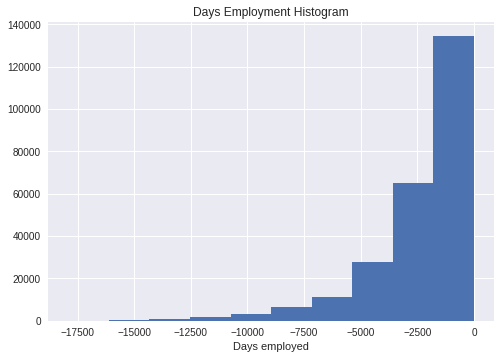

In [17]:
data['DAYS_EMPLOYED'].hist()
plt.xlabel('Days employed')
plt.title('Days Employment Histogram')
plt.show()

#### Anything we do with the training data must also be done with the testing data

In [18]:
test_data['DAYS_EMPLOYED_ANOM'] = test_data["DAYS_EMPLOYED"] == 365243
test_data["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (test_data["DAYS_EMPLOYED_ANOM"].sum(), len(test_data)))

There are 9274 anomalies in the test data out of 48744 entries


# Correlations

In [19]:
# Find correlations with the target and sort
correlations = data.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64


In [20]:
print('Most Negative Correlations:\n', correlations.head(15))

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_ANOM                     -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
Name: TARGET, dtype: float64


#### Negative correlation

We see that Day's birth has a negative value but it is positively correlated to the target variable. This can be confusing, hence we take the absolute value.

In [21]:
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_BIRTH'].corr(data['TARGET'])

-0.078239308309826935

Now the values are negatively correlated. This means that as the client gets older, he is more likely to default his loan on time.

# Distribution

The distribution of ages does not tell much by itself but it's good to spot outliers if there are any.

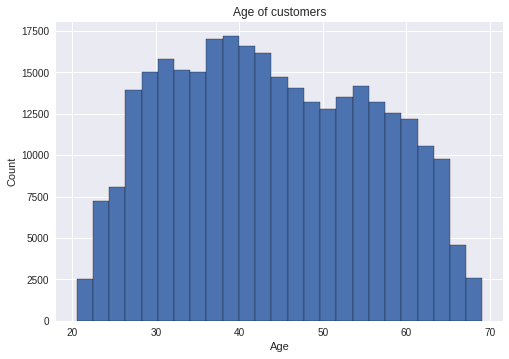

In [22]:
plt.hist(data['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title('Age of customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Effect of age on target

To visualize the effect of age on target we make a KDE (kernel density plot) which can be thought of as a smoothed histogram.

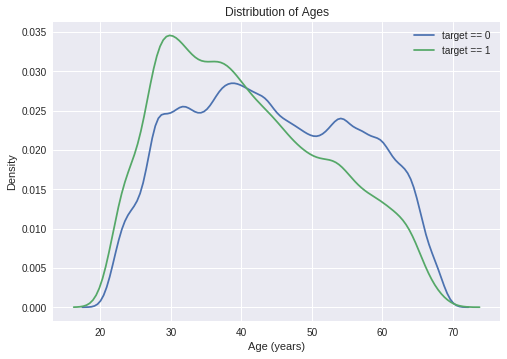

In [23]:
# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.title('Distribution of Ages')
plt.xlabel('Age (years)')
plt.ylabel('Density')

plt.show()

# Age bins

We can also look at the relationship in another way. We use 5 year bins for age, then for each bin we calculate the average value of target

In [24]:
# Age information into a separate dataframe
age_data = data[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
# 20 to 70 is the range
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
# type(age_data['YEARS_BINNED'])
age_data.head(10)

/home/dipamvasani7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dipamvasani7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [25]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


In [26]:
# there is a clear trend that as age increases, 
(age_groups['TARGET'] * 100)

YEARS_BINNED
(20.0, 25.0]    12.303643
(25.0, 30.0]    11.143570
(30.0, 35.0]    10.281440
(35.0, 40.0]     8.941402
(40.0, 45.0]     7.849104
(45.0, 50.0]     7.417105
(50.0, 55.0]     6.696812
(55.0, 60.0]     5.531401
(60.0, 65.0]     5.273693
(65.0, 70.0]     3.727015
Name: TARGET, dtype: float64

# Feature engineering

Feature engineering is the process of identifying and extracting predictive features in the complex data. It includes both feature construction and feature selection and is a very important step.

In [27]:
# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# check for missing values
poly_features.isnull().sum()

EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
DAYS_BIRTH           0
TARGET               0
dtype: int64

In [28]:
# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(['TARGET'], axis=1)

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

In [29]:
from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [30]:
# to see the features
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:10]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2']

In [31]:
# Create a dataframe of the features
# poly_features was a numpy array
poly_features = pd.DataFrame(poly_features, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
# poly_features.head()

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print()
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64

DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


### Adding them to the main data frame

Since the new features have larger correlation with the target than the original, we add them to the table

In [32]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
app_train_poly = data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test_data['SK_ID_CURR']
app_test_poly = test_data.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


## Domain knowledge features

We use 4 features inspired by another script

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age


In [33]:
app_train_domain = data.copy()
app_test_domain = test_data.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [34]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

/home/dipamvasani7/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/dipamvasani7/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


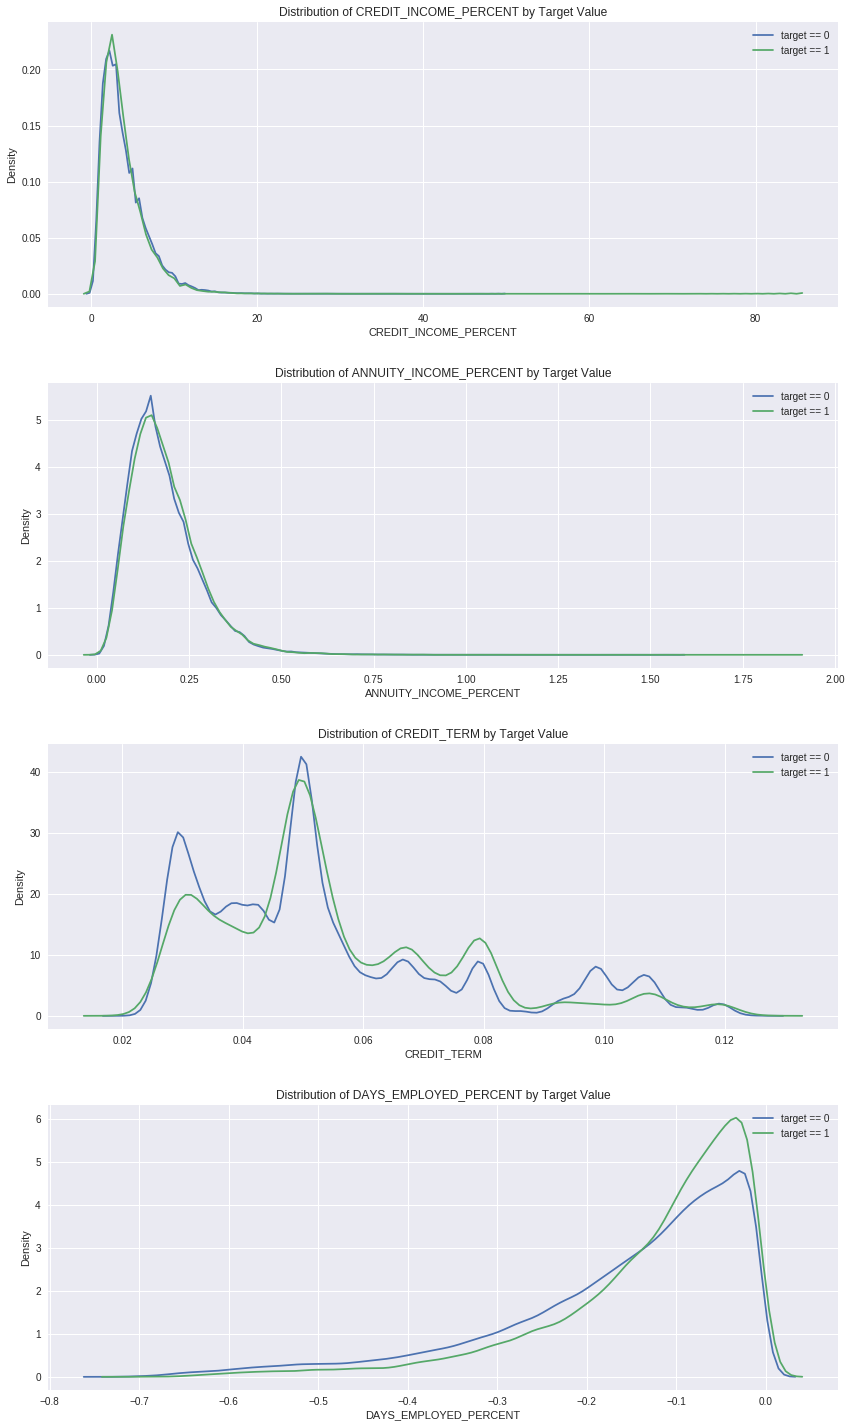

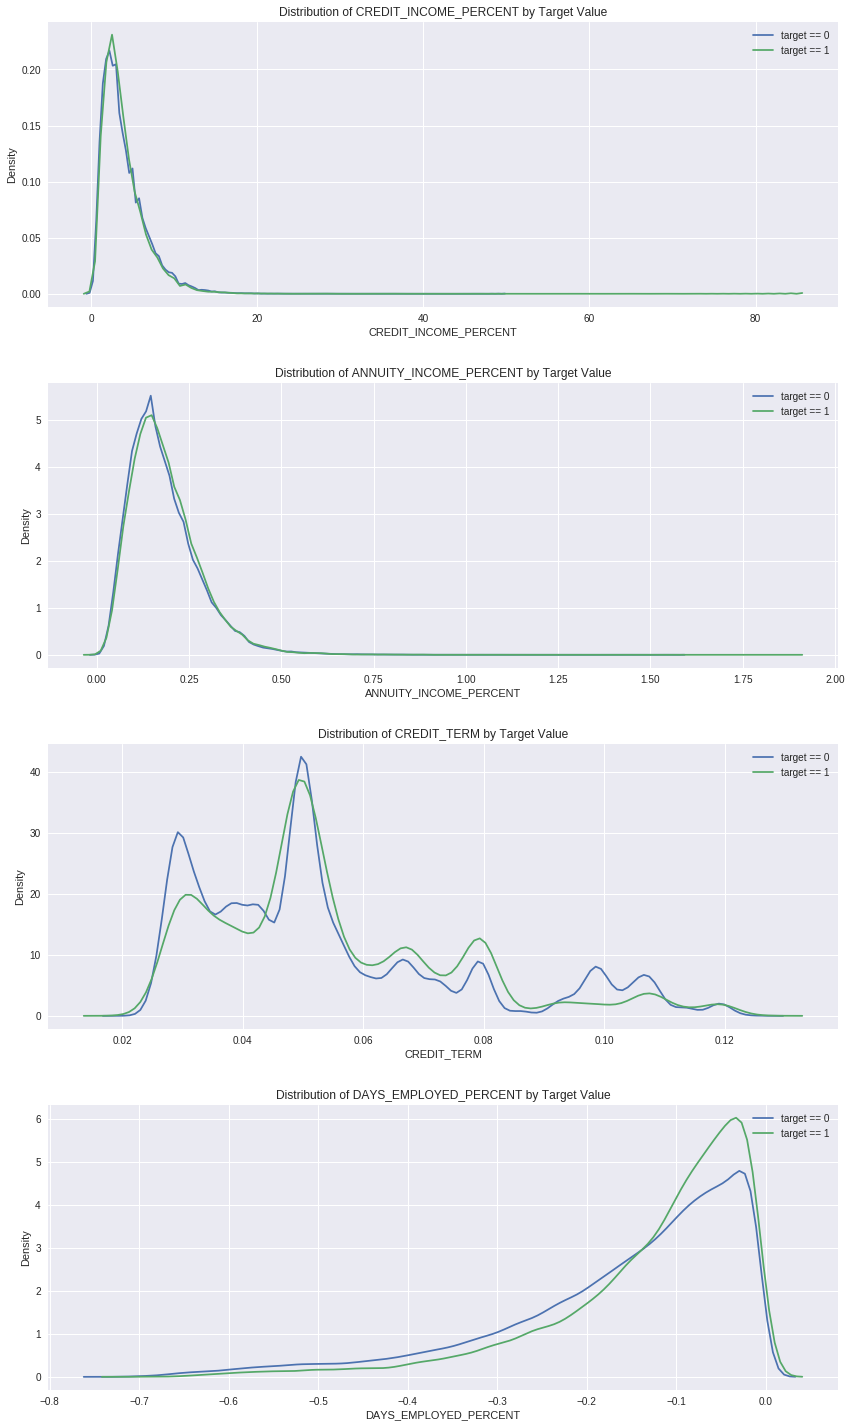

In [36]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
plt.show()

In [39]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in data:
    train = data.drop(['TARGET'], axis=1)
else:
    train = data.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = test_data.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [40]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [53]:
# Make predictions
# Make sure to select the second column only
# The first column is the probability that the entry has the 1 label and 
# the second column is the probability that the entry has the 0 label
log_reg_pred = log_reg.predict_proba(test)[:, 1]
print(log_reg_pred[0])

0.0877503708316


In [44]:
# Submission dataframe
submit = test_data[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

/home/dipamvasani7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.087750
1,100005,0.163957
2,100013,0.110238
3,100028,0.076575
4,100038,0.154924


In [54]:
# Save to a csv file
# submit.to_csv('log_reg_baseline.csv', index = False)